자산배분은 상관관계가 낮거나 음수인 우상향하는 자산들에 분산 투자하는 것입니다. 가장 기본적이고, 잘 알려진 방식은 주식 60 : 채권 40 방식입니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


ETF로 매수하는 것이 간편한데, 테스트 기간을 더 늘리기 위해서 상관관계 체크 후 펀드 데이터로 적용합니다.

In [2]:
# S&P 500 (VFINX), US Long Term Treasury (VUSTX)
# VFINX start: 1976-08-31, VUSTX start: 1986-05-19
start = '1986-05-19'
end = '2021-02-12'
vfinx = web.DataReader("VFINX", 'yahoo', start, end)['Adj Close'].to_frame("Close")
vustx = web.DataReader("VUSTX", 'yahoo', start, end)['Adj Close'].to_frame("Close")

spy = web.DataReader("SPY", 'yahoo', start, end)['Adj Close'].to_frame("SPY")
tlt = web.DataReader("TLT", 'yahoo', start, end)['Adj Close'].to_frame("TLT")

상관관계를 체크합니다. vfinx와 spy, vustx와 tlt를 체크하기 위해서 join 합니다.

In [3]:
vfinx_cor = vfinx.join(spy).dropna(axis=0)
vustx_cor = vustx.join(tlt).dropna(axis=0)

In [4]:
vfinx_cor.corr(method = 'pearson')

,Close,SPY
Close,1.000000,0.999995
SPY,0.999995,1.000000


In [5]:
vustx_cor.corr(method = 'pearson')

,Close,TLT
Close,1.000000,0.994689
TLT,0.994689,1.000000


VFINX와 SPY의 상관계수는 1993년 1월 29일부터 2021년 2월 9일까지 0.999995, VUSTX와 TLT의 상관계수는 2002년 7월 30일부터 2021년 2월 9일까지 0.99472입니다. 이 정도면 ETF인 SPY와 TLT 대신 VFINX와 VUSTX를 사용해도 무방할 것입니다.

Backtrader 패키지를 사용하는데, input 형식을 맞추어야 합니다.

In [6]:
for column in ['Open', 'High', "Low"]:
    vfinx[column] = vfinx["Close"]
    vustx[column] = vustx["Close"]

60 : 40 비율로 매수하고 20 거래일마다 리밸런싱하는 전략입니다. 

In [7]:
class AssetAllocation_6040(bt.Strategy):
    params = (
        ('equity',0.6),
    )
    def __init__(self):
        self.VFINX = self.datas[0]
        self.VUSTX = self.datas[1]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VFINX, target=self.params.equity)
            self.order_target_percent(self.VUSTX, target=(1 - self.params.equity))
        self.counter += 1

In [8]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VFINX = bt.feeds.PandasData(dataname = vfinx)
VUSTX = bt.feeds.PandasData(dataname = vustx)

cerebro.adddata(VFINX)
cerebro.adddata(VUSTX)

cerebro.addstrategy(AssetAllocation_6040)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

quantstats.reports.html(returns, output = 'Report_AssetAllocation_6040.html', title='AssetAllocation_6040')

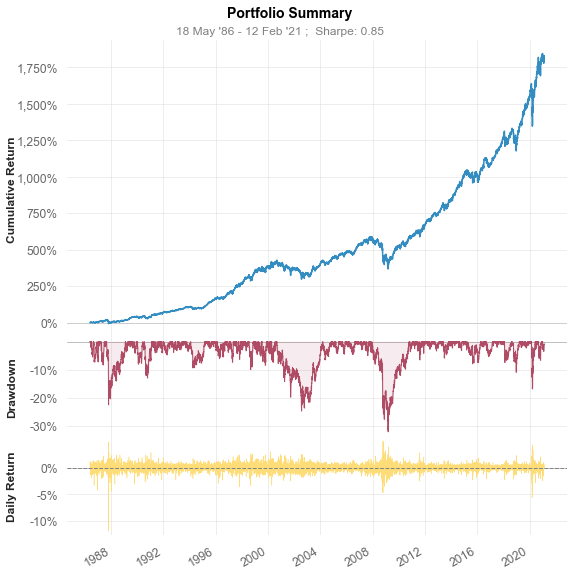

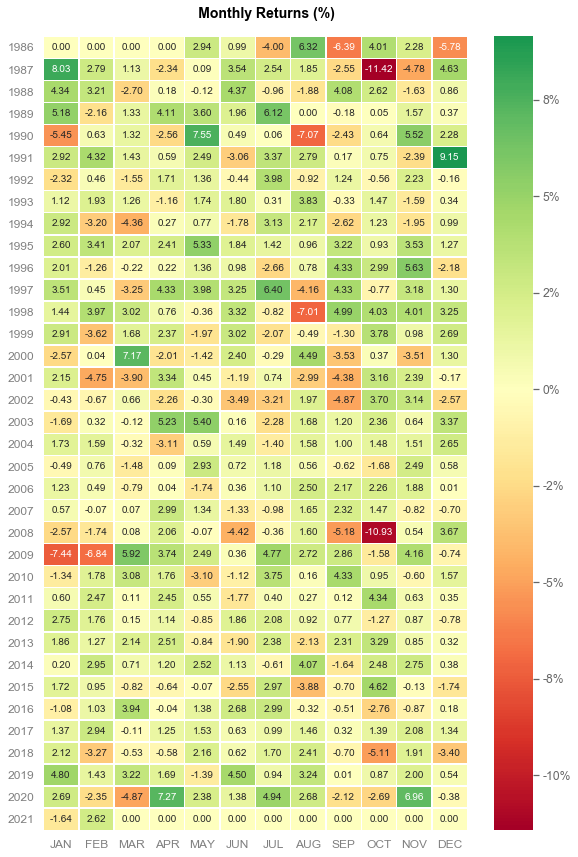

In [9]:
quantstats.reports.plots(returns, mode='basic')

In [10]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               1986-05-19
End Period                 2021-02-12
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          1,827.58%
CAGR%                      8.88%
Sharpe                     0.85
Sortino                    1.19
Max Drawdown               -32.01%
Longest DD Days            1277
Volatility (ann.)          10.67%
Calmar                     0.28
Skew                       -0.92
Kurtosis                   16.54

Expected Daily %           0.03%
Expected Monthly %         0.71%
Expected Yearly %          8.57%
Kelly Criterion            7.9%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.07%
Expected Shortfall (cVaR)  -1.07%

Payoff Ratio               0.94
Profit Factor              1.17
Common Sense Ratio         1.16
CPC Index                  0.61
Tail Ratio                 0.99
Outlier Win Ratio          3.77
Outlier Loss Ratio       